5.666756353541589

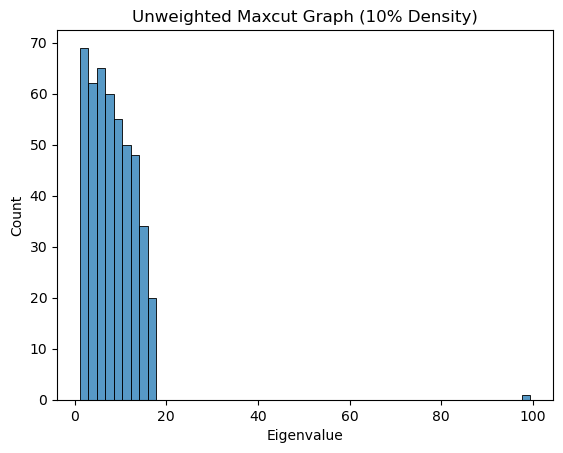

In [359]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
from tqdm import tqdm
device = 'cuda:0'
G = nx.erdos_renyi_graph(n=500, p=.2)
while nx.is_connected(G) == False:
    G = nx.erdos_renyi_graph(n=500, p=.2)
edges = np.random.choice([-1,1], G.number_of_edges())
# for i, e in enumerate(G.edges()):
#     G.edges[e[0], e[1]]['weight'] = edges[i]

# eweights = G.edges()
A = -torch.tensor(nx.to_numpy_array(G, np.arange(G.number_of_nodes()), weight='weight'), device=device)
blocks = np.array_split(np.arange(G.number_of_nodes()), 8)
JInternal = torch.block_diag(*[A[np.ix_(b,b)] for b in blocks] )
JExt = A - JInternal
eig = torch.linalg.eigh(A)
vals = torch.linalg.eigvals(A).cpu().numpy().real
vals = np.abs(vals[np.abs(vals) > 1])

ax=sns.histplot(vals)
ax.set_xlabel('Eigenvalue')
ax.set_title('Unweighted Maxcut Graph (10% Density)')
vals[0] / vals[1]

In [296]:
leading_eig = eig.eigenvectors[:,0]
leading_eig

tensor([-0.0389, -0.0494, -0.0397, -0.0509, -0.0381, -0.0561, -0.0386, -0.0445,
        -0.0474, -0.0354, -0.0323, -0.0402, -0.0438, -0.0532, -0.0470, -0.0398,
        -0.0392, -0.0485, -0.0489, -0.0443, -0.0473, -0.0469, -0.0363, -0.0405,
        -0.0411, -0.0440, -0.0414, -0.0503, -0.0375, -0.0424, -0.0459, -0.0445,
        -0.0434, -0.0361, -0.0404, -0.0436, -0.0369, -0.0549, -0.0403, -0.0389,
        -0.0497, -0.0487, -0.0454, -0.0452, -0.0461, -0.0492, -0.0356, -0.0357,
        -0.0406, -0.0468, -0.0449, -0.0584, -0.0365, -0.0429, -0.0473, -0.0408,
        -0.0404, -0.0445, -0.0349, -0.0586, -0.0383, -0.0526, -0.0400, -0.0386,
        -0.0375, -0.0332, -0.0482, -0.0439, -0.0387, -0.0405, -0.0358, -0.0499,
        -0.0417, -0.0410, -0.0540, -0.0473, -0.0493, -0.0484, -0.0485, -0.0402,
        -0.0424, -0.0511, -0.0366, -0.0446, -0.0469, -0.0472, -0.0484, -0.0488,
        -0.0426, -0.0287, -0.0464, -0.0450, -0.0462, -0.0430, -0.0388, -0.0370,
        -0.0407, -0.0406, -0.0595, -0.05

1.0205353140080464

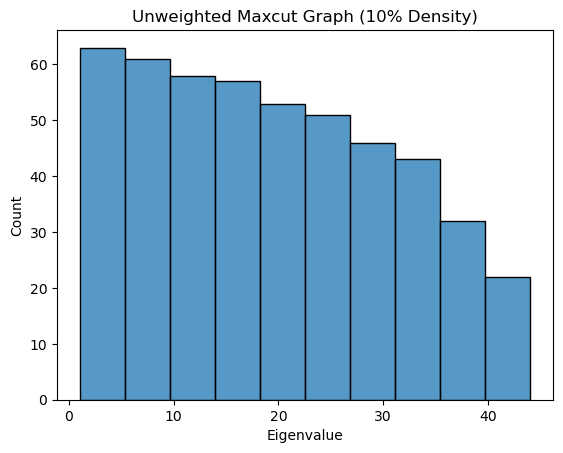

In [347]:

G = nx.erdos_renyi_graph(n=500, p=1)
while nx.is_connected(G) == False:
    G = nx.erdos_renyi_graph(n=500, p=1)
edges = np.random.choice([-1,1], G.number_of_edges())
for i, e in enumerate(G.edges()):
    G.edges[e[0], e[1]]['weight'] = edges[i]

# eweights = G.edges()
A = -torch.tensor(nx.to_numpy_array(G, np.arange(G.number_of_nodes()), weight='weight'), device=device)
blocks = np.array_split(np.arange(G.number_of_nodes()), 8)
JInternal = torch.block_diag(*[A[np.ix_(b,b)] for b in blocks] )
JExt = A - JInternal
eig = torch.linalg.eigh(A)
vals = torch.linalg.eigvals(A).cpu().numpy().real
vals = np.abs(vals[np.abs(vals) > 1])

ax=sns.histplot(vals)
ax.set_xlabel('Eigenvalue')
ax.set_title('Unweighted Maxcut Graph (10% Density)')
vals[0] / vals[1]

In [393]:

R = 31e3
C = 200e-15
def concurrent_langevin(G, J:torch.tensor, x0:torch.tensor, blocks, time: float, dt: float, sync_epoch: float, gamma=20, gamma_min=5):
    JInternal = torch.block_diag(*[J[np.ix_(b,b)] for b in blocks] )
    JExt = J - JInternal
    tsteps = int(np.ceil(time / dt))
    sched = torch.linspace(0.5, 0.5, tsteps)
    sync_steps = int(np.ceil(sync_epoch / dt))
    print(sync_steps)
    x_copy = x0.clone().detach().sign()
    x = x0.clone().detach()
    prev_noise = torch.randn_like(x)
    sumW = -A.sum() / 2
    vals = []
    vals_copy = []
    prox = []
    print(sync_steps)
    gamma_sched = torch.linspace(gamma, gamma_min, tsteps)

    for i in tqdm(range(tsteps)):
        next_noise = torch.randn_like(x)
        grad1 = JInternal.matmul(x)
        grad2 = JExt.matmul(x_copy)
        x = torch.clip(x + dt/(R*C) * (grad1 + grad2 + gamma_sched[i] * x) + sched[i] * np.sqrt(dt/(2 * R*C)) * (prev_noise + next_noise), -1, 1)
        prev_noise = next_noise
        if i % sync_steps == 0:
            x_copy = x.sign()
        xs = x.sign()
        xcs = x_copy.sign()
        prox.append(grad2.norm(dim=1).mean().item())
        cut = (sumW + 0.5*xs.T.matmul(J.matmul(xs))) / 2
        cut_other = (sumW + 0.5 * (xs.T.matmul(JInternal.matmul(xs) + JExt.matmul(xcs)))) / 2
        vals.append((cut).mean().item())
        vals_copy.append(cut_other.mean().item())

    return x, np.array(vals), np.array(vals_copy), np.array(prox)
        
        
x0 = torch.randn((G.number_of_nodes(), 40), device=device).clip(-1, 1).double()
    # print(Jblock)
# x0 = torch.randn((G.number_of_nodes(),)).clip(-1, 1).double()
# data = []
# for i in tqdm(np.linspace(1e-3, 3, 20)):
#     for t in range(20):
#         spins = concurrent_langevin(A, x0, np.array_split(np.arange(G.number_of_nodes()), 4), 10, 1e-3, i)
#         spins = (spins > 0).int() -( spins < 0).int()
#         S = [i for i, s in enumerate(spins) if s == 1]
#         cut = nx.cut_size(G, S)
#         data.append((i, cut, t))
# x1, v2, vc2, p1 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 8), 1e-8, 2e-12, 1e-10, 0)
# x1, v3, vc3, p2 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 8), 1e-8, 2e-12, .4e-9, 10)
# x1, v4, vc4, p3 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 8), 1e-8, 2e-12, .6e-9, )
# x1, v5, vc5, p4 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 8), 1e-8, 2e-12, .8e-9)
x1, v1, vc6, p5 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 8), 1e-8, 2e-12, 1e-11, 0, 0)
x1, v2, vc6, p5 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 8), 1e-8, 2e-12, 1e-9, 30, 10)
x1, v3, vc6, p5 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 8), 1e-8, 2e-12, 1e-9, 30, 8)
x1, v4, vc6, p5 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 8), 1e-8, 2e-12, 1e-9, 30, 6)
x1, v5, vc6, p5 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 8), 1e-8, 2e-12, 1e-9, 30, 4)
x1, v6, vc6, p5 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 8), 1e-8, 2e-12, 1e-9, 30, 2)
# x1, v7, vc7, p6 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 8), 1e-8, 2e-12, 2e-9)
# x1, v8, vc8, p7 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 8), 1e-8, 2e-12, 3e-9)

5
5


100%|██████████| 5000/5000 [00:01<00:00, 2890.41it/s]


501
501


100%|██████████| 5000/5000 [00:01<00:00, 2933.60it/s]


501
501


100%|██████████| 5000/5000 [00:01<00:00, 2943.25it/s]


501
501


100%|██████████| 5000/5000 [00:01<00:00, 2943.31it/s]


501
501


100%|██████████| 5000/5000 [00:01<00:00, 2934.07it/s]


501
501


100%|██████████| 5000/5000 [00:01<00:00, 2878.81it/s]


[11.855422496749874, 14.00394035665261, 20.779208889400888]

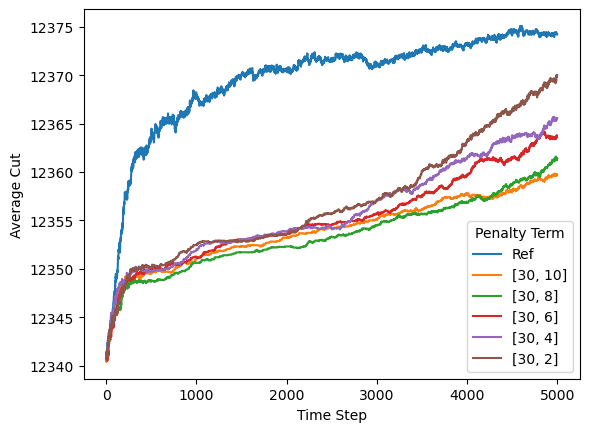

In [396]:
import pandas as pd
import matplotlib.pyplot as plt
# sns.lineplot(x=np.arange(len(v2)), y=vc2-v2)
# sns.lineplot(x=np.arange(len(v2)), y=vc3-v3)
ax = sns.lineplot(x=np.arange(len(v1)), y=v1, label='Ref')
ax = sns.lineplot(x=np.arange(len(v2)), y=v2, label='[30, 10]')
ax = sns.lineplot(x=np.arange(len(v2)), y=v3, label='[30, 8]')
ax = sns.lineplot(x=np.arange(len(v2)), y=v4, label='[30, 6]')
ax = sns.lineplot(x=np.arange(len(v2)), y=v5, label='[30, 4]')
ax = sns.lineplot(x=np.arange(len(v2)), y=v6, label='[30, 2]')
# ax = sns.lineplot(x=np.arange(len(v2)), y=v6, label='9')
# ax = sns.lineplot(x=np.arange(len(v2)), y=v7, label='3')
# ax = sns.lineplot(x=np.arange(len(v2)), y=v8, label='5')
ax.set_ylabel('Average Cut')
ax.set_xlabel('Time Step')
# ax.set_yscale('log')
ax.legend(title='Penalty Term')
[np.var(i) for i in [v2, v3, v4]]

[15.320681003894864, 13.35701550090274, 20.01044368942356]

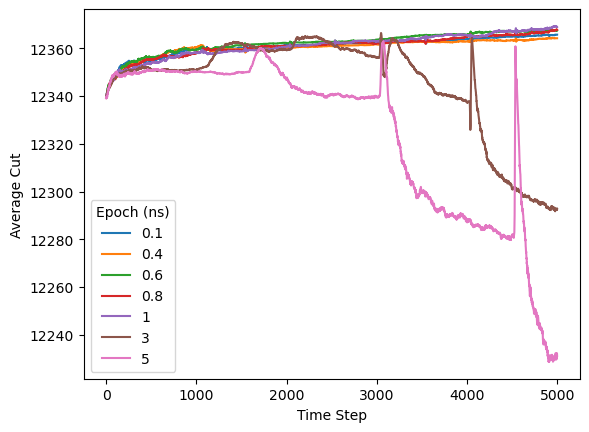

In [383]:
import pandas as pd
import matplotlib.pyplot as plt
# sns.lineplot(x=np.arange(len(v2)), y=vc2-v2)
# sns.lineplot(x=np.arange(len(v2)), y=vc3-v3)
ax = sns.lineplot(x=np.arange(len(v2)), y=v2, label='0.1')
ax = sns.lineplot(x=np.arange(len(v2)), y=v3, label='0.4')
ax = sns.lineplot(x=np.arange(len(v2)), y=v4, label='0.6')
ax = sns.lineplot(x=np.arange(len(v2)), y=v5, label='0.8')
ax = sns.lineplot(x=np.arange(len(v2)), y=v6, label='1')
# ax = sns.lineplot(x=np.arange(len(v2)), y=v6, label='9')
ax = sns.lineplot(x=np.arange(len(v2)), y=v7, label='3')
ax = sns.lineplot(x=np.arange(len(v2)), y=v8, label='5')
ax.set_ylabel('Average Cut')
ax.set_xlabel('Time Step')
# ax.set_yscale('log')
ax.legend(title='Epoch (ns)')
[np.var(i) for i in [v2, v3, v4]]

[7.544421832489752, 4.514221538602439, 4.668134108786935]

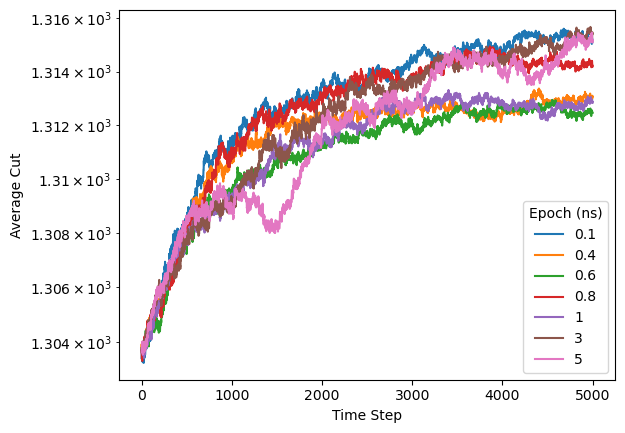

In [318]:
import pandas as pd
import matplotlib.pyplot as plt
# sns.lineplot(x=np.arange(len(v2)), y=vc2-v2)
# sns.lineplot(x=np.arange(len(v2)), y=vc3-v3)
ax = sns.lineplot(x=np.arange(len(v2)), y=v2, label='0.1')
ax = sns.lineplot(x=np.arange(len(v2)), y=v3, label='0.4')
ax = sns.lineplot(x=np.arange(len(v2)), y=v4, label='0.6')
ax = sns.lineplot(x=np.arange(len(v2)), y=v5, label='0.8')
ax = sns.lineplot(x=np.arange(len(v2)), y=v6, label='1')
# ax = sns.lineplot(x=np.arange(len(v2)), y=v6, label='9')
ax = sns.lineplot(x=np.arange(len(v2)), y=v7, label='3')
ax = sns.lineplot(x=np.arange(len(v2)), y=v8, label='5')
ax.set_ylabel('Average Cut')
ax.set_xlabel('Time Step')
ax.set_yscale('log')
ax.legend(title='Epoch (ns)')
[np.var(i) for i in [v2, v3, v4]]

[255.26218311164962, 9916.599328402368, 8671.075172457173]

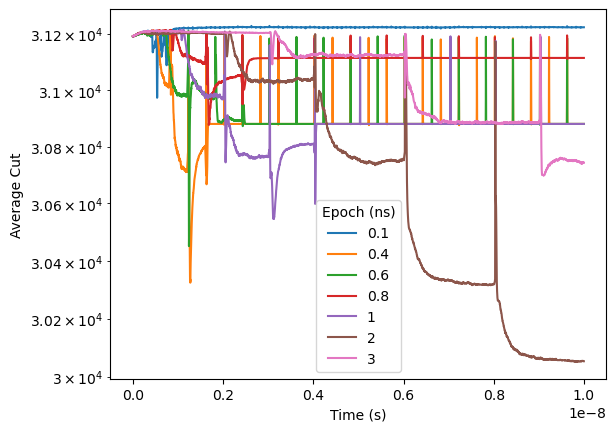

In [226]:
import pandas as pd
import matplotlib.pyplot as plt
# sns.lineplot(x=np.arange(len(v2)), y=vc2-v2)
# sns.lineplot(x=np.arange(len(v2)), y=vc3-v3)
ax = sns.lineplot(x=np.arange(len(v2))*2e-12, y=v2, label='0.1')
ax = sns.lineplot(x=np.arange(len(v2))*2e-12, y=v3, label='0.4')
ax = sns.lineplot(x=np.arange(len(v2))*2e-12, y=v4, label='0.6')
ax = sns.lineplot(x=np.arange(len(v2))*2e-12, y=v5, label='0.8')
ax = sns.lineplot(x=np.arange(len(v2))*2e-12, y=v6, label='1')
ax = sns.lineplot(x=np.arange(len(v2))*2e-12, y=v7, label='2')
ax = sns.lineplot(x=np.arange(len(v2))*2e-12, y=v8, label='3')
ax.set_ylabel('Average Cut')
ax.set_xlabel('Time (s)')
ax.set_yscale('log')
ax.legend(title='Epoch (ns)')
# sns.lineplot(x=np.arange(len(v2)), y=v2)
# sns.lineplot(x=np.arange(len(v2)), y=v3)
# sns.lineplot(x=np.arange(len(v2)), y=v4)
[np.var(i) for i in [v2, v3, v4]]

[15.489755229164338, 15661.0218680134, 820.8473976637805]

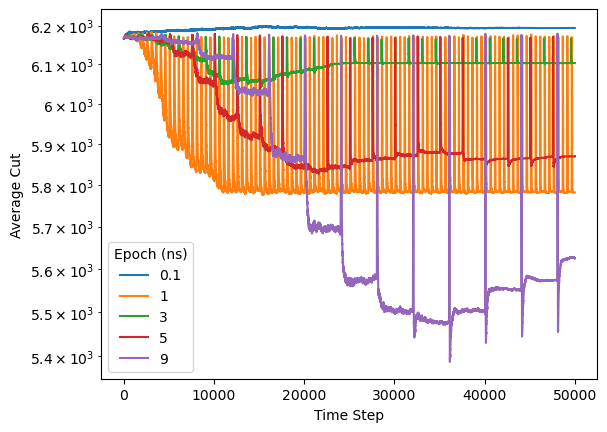

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
# sns.lineplot(x=np.arange(len(v2)), y=vc2-v2)
# sns.lineplot(x=np.arange(len(v2)), y=vc3-v3)
ax = sns.lineplot(x=np.arange(len(v2)), y=v2, label='0.1')
ax = sns.lineplot(x=np.arange(len(v2)), y=v3, label='1')
ax = sns.lineplot(x=np.arange(len(v2)), y=v4, label='3')
ax = sns.lineplot(x=np.arange(len(v2)), y=v5, label='5')
ax = sns.lineplot(x=np.arange(len(v2)), y=v6, label='9')
ax.set_ylabel('Average Cut')
ax.set_xlabel('Time Step')
ax.set_yscale('log')
ax.legend(title='Epoch (ns)')
# sns.lineplot(x=np.arange(len(v2)), y=v2)
# sns.lineplot(x=np.arange(len(v2)), y=v3)
# sns.lineplot(x=np.arange(len(v2)), y=v4)
[np.var(i) for i in [v2, v3, v4]]

2001
2001


100%|██████████| 20000/20000 [00:02<00:00, 8169.11it/s]


[14186.922662677496, 24941.811935937498, 28187.162051639996]

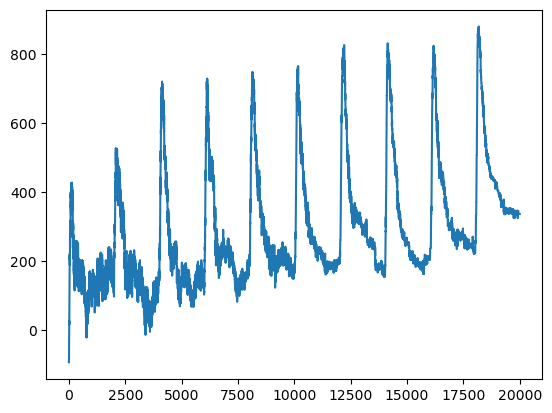

In [139]:
import pandas as pd

# sns.lineplot(x=np.arange(len(v2)), y=vc2-v2)
# sns.lineplot(x=np.arange(len(v2)), y=vc3-v3)

x1, v4, vc4 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 4), 1e-7, 5e-12, 1e-8)
sns.lineplot(x=np.arange(len(v2)), y=v4)
# sns.lineplot(x=np.arange(len(v2)), y=v2)
# sns.lineplot(x=np.arange(len(v2)), y=v3)
# sns.lineplot(x=np.arange(len(v2)), y=v4)
[np.var(i) for i in [v2, v3, v4]]